In [22]:
import itertools
import csv



import numpy as np


import matplotlib.pyplot as plt


import scipy.integrate as integrate
import torch


from torchquad import set_up_backend


from torchquad import Trapezoid, Simpson, MonteCarlo


from torch import exp, sqrt, sin, cos

In [51]:
set_up_backend("torch", data_type="float32")
tp = Trapezoid()

## Konstante i osnovne funkcije

In [34]:
kb = 8.6173303 * 10 ** (-5)
hbar = 6.582119569 * 10 ** (-16)
pi = np.pi

alpha_op = 0.4
alpha_ac = 1
hbar_w_op = torch.Tensor([0.4]).to("cuda")
eta_0 = 1 * 10 ** (-3)
M = 0.0
Kf_20 = 0.2  # eV, Fermi at 20K
vf = 4 * 10**5
a = 100 ** (1 / 3) * 10 ** (-10)
T_0 = 4
T_F = Kf_20 / kb
n = 10 ^ 30

Kf_ = Kf_20 / hbar / vf * a  # Fermi unitless
Kf_max = 1 / hbar / vf * a  # cutoff 1eV unitless
c_s_tilde = 0.03  # hbar_w_ac_max / hbar / vf * a
hbar_w_ac_max = c_s_tilde * hbar * vf / a
G_op2 = alpha_op
G_ac2 = alpha_ac * hbar * vf / a


Ef = sqrt(torch.FloatTensor([Kf_20**2 + M**2])).to("cuda")

In [25]:
def arrays_to_csv(array1, array2, name):
    with open(f"{name}.csv", "w", newline="") as file:
        writer = csv.writer(file)
        for a1, a2 in zip(array1, array2):
            writer.writerow([round(a1, 5), a2])

In [84]:
def fermi_dirac(E, Ef, T):
    if T > 0:
        return torch.where(
            E > Ef,
            exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1),
            1 / (exp((E - Ef) / (kb * T)) + 1),
        )
    else:
        return torch.where(E < Ef, 0, 1)


def d_fermi_dirac(E, Ef, T):
    return 1 / kb / T * fermi_dirac(E, Ef, T) * (1 - fermi_dirac(E, Ef, T))


def bose_einstein(E, T):
    assert T > 0
    return exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1)


def chemical_potential(T):
    return (
        Ef
        - pi**2 / 6 * (2 * Ef**2 - M**2) / Ef / (Ef**2 - M**2) * (kb * T) ** 2
        - 7 / 360 * pi**4 * 3 * M**4 / Ef / (Ef**2 - M**2) ** 3 * (kb * T) ** 4
    )


def eps(K):
    return sqrt(hbar**2 * vf**2 / a**2 * K**2 + M**2)


def eff_concetration(T):
    def integrand(k):
        return d_fermi_dirac(eps(k), Ef, T) * k**2

    integral = tp.integrate(
        integrand, dim=1, N=10**6, integration_domain=torch.Tensor([[0, Kf_max]])
    )
    return 4 * pi / 3 * 2 / (2 * pi) ** 3 * vf**2 * integral

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


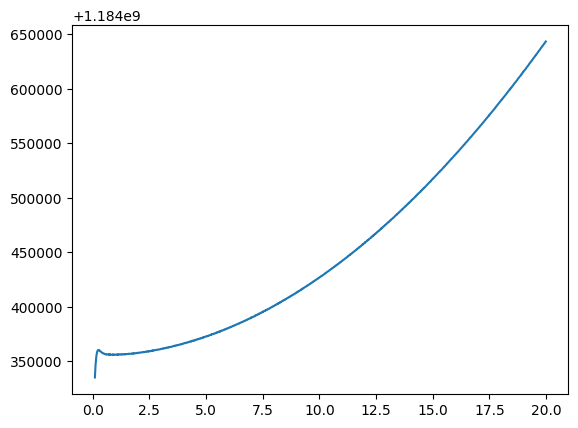

In [ ]:
Ts = torch.arange(0.1, 20, 0.01).to("cuda")
ints = [eff_concetration(t).to("cpu") for t in Ts]
plt.plot(Ts.cpu(), ints)

In [83]:
4 * pi / 3 * 2 / (2 * pi) ** 3 * Kf_20**2 / hbar**3 / vf

1.184354454914293e+37

In [79]:
ints

[tensor(1.1851e+09, device='cpu'),
 tensor(1.1843e+09, device='cpu'),
 tensor(1.1843e+09, device='cpu'),
 tensor(1.1843e+09, device='cpu'),
 tensor(1.1843e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, device='cpu'),
 tensor(1.1844e+09, 

In [28]:
ws_0 = torch.arange(0, 1, 0.001)


def calculate_integral_points(
    mem_fn, real_sum, imag_sum, hbar_w_ph, T=T_0, eta=eta_0, ws=ws_0, u=Kf_20
):

    result_real = []

    result_imag = []

    for w in ws:

        result_real.append(
            mem_fn(
                real_sum,
                w,
                hbar_w_ph,
                u,
                T=T,
                eta=eta,
            ).to("cpu")
        )

        result_imag.append(
            mem_fn(
                imag_sum,
                w,
                hbar_w_ph,
                u,
                T=T,
                eta=eta,
            ).to("cpu")
        )

    return result_real, result_imag


def setup_plot(real=True, imag=True, x_lim=[0.0, 0.05], y_lim=[0, 0.06]):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel(r"$\hbar \omega [eV]$")

    if real:

        ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$")

    else:

        ax1.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax1.set_xlim(x_lim)

    ax1.set_ylim(y_lim)

    ax2 = ax1.twinx()

    if imag and real:

        ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax2.set_xlim(x_lim)

    ax2.set_ylim(y_lim)

    return fig, ax1, ax2


def plot_real_and_imag_result(
    ax1, ax2, result_real, result_imag, T=None, eta=None, ws=ws_0
):
    assert T or eta

    ax1.plot(
        ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV"
    )

    ax2.plot(ws.to("cpu"), result_imag)

    if T:

        plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)

    else:

        plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)


def plot_result(ax, result, T=None, eta=None, ws=ws_0):

    ax.plot(ws.to("cpu"), result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")

<>:76: SyntaxWarning: invalid escape sequence '\e'
<>:83: SyntaxWarning: invalid escape sequence '\e'
<>:92: SyntaxWarning: invalid escape sequence '\e'
<>:76: SyntaxWarning: invalid escape sequence '\e'
<>:83: SyntaxWarning: invalid escape sequence '\e'
<>:92: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_7008\4046195994.py:76: SyntaxWarning: invalid escape sequence '\e'
  ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV"
C:\Users\Patrik\AppData\Local\Temp\ipykernel_7008\4046195994.py:83: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
C:\Users\Patrik\AppData\Local\Temp\ipykernel_7008\4046195994.py:92: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(ws.to("cpu"), result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")


## Optički fononi


**Memorijska funkcija**

In [ ]:
def ss_sum_part(K_, K, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        return (
            bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)
        ) / (hbar_w + s1 * eps(K_) - s1 * eps(K) + s2 * hbar_w_ph + eta * 1j)

    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2 * K_**2 * d_fermi_dirac(eps(K_), Ef, T) * (1 / 3 * vf**2)


def ss_sum_real(K_, K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K_, K, hbar_w, hbar_w_ph, T, u, eta).real


def ss_sum_imag(K_, K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K_, K, hbar_w, hbar_w_ph, T, u, eta).imag


def mem_fn_op(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integration_domain = torch.Tensor([[0, Kf_max], [0, Kf_max]])

    def integrand(K):
        return ss_sum_fn(K[:, 0], K[:, 1], hbar_w, hbar_w_ph, T, u, eta)

    integral_k_k_ = tp.integrate(
        integrand, dim=2, N=10**6, integration_domain=integration_domain
    )

    return (
        -G_op2 * integral_k_k_ / (2 * pi) ** 2 * 2 / (2 * pi) ** 2 * 2
    )  # one factor 2 for 4\pi

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


AttributeError: 'list' object has no attribute 'to'

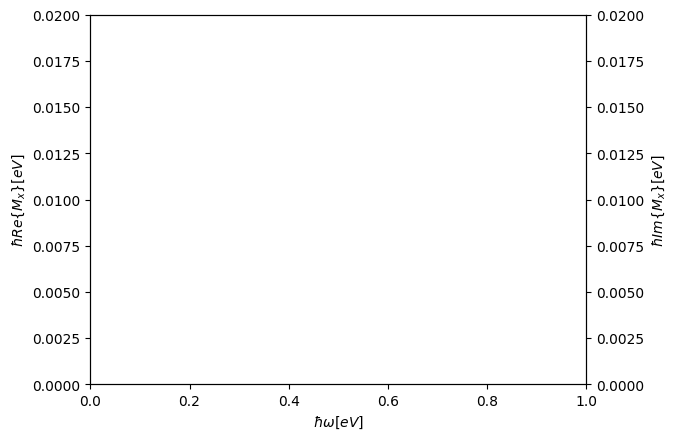

In [36]:
fig, *axs = setup_plot(x_lim=[0, 1], y_lim=[0, 0.02])
integrals = calculate_integral_points(
    mem_fn_op, ss_sum_real, ss_sum_imag, hbar_w_op, T=T_0
)
arrays_to_csv(ws_0, integrals[0].to("cpu"), f"op, real, T={T_0}K, eta={eta_0}eV")
arrays_to_csv(ws_0, integrals[1].to("cpu"), f"op, imag, T={T_0}K, eta={eta_0}eV")
plot_real_and_imag_result(*axs, *integrals, T=T_0)
axs[0].legend(loc="best")
fig.tight_layout()

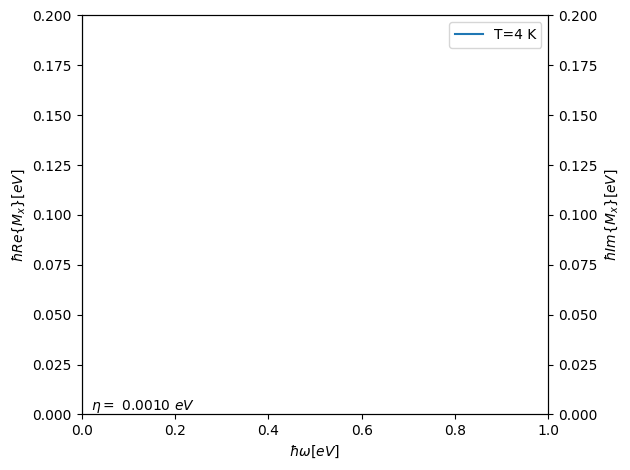

In [38]:
fig, *axs = setup_plot(x_lim=[0, 1], y_lim=[0, 0.2])
plot_real_and_imag_result(*axs, *integrals, T=T_0)
axs[0].legend(loc="best")
fig.tight_layout()

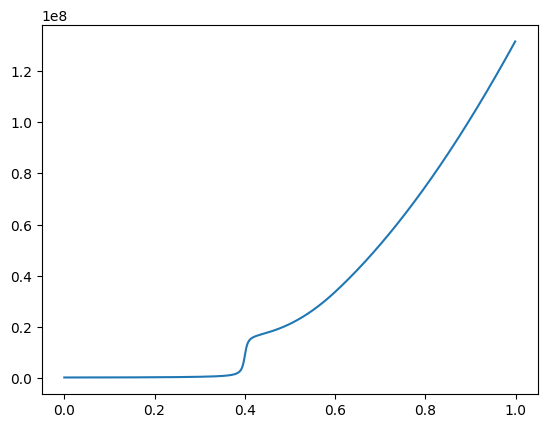

In [50]:
plt.plot(ws_0.to("cpu"), integrals[1])

## Akustični fononi

In [78]:
def ss_sum_part(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        abs_K = sqrt(K**2 + Kf_**2 - 2 * Kf_ * K * sin(theta) * cos(phi))
        factor = 1 - K * sin(theta) * cos(phi) * Ef / eps(K) / Kf_
        return (bose_einstein(hbar_w_ph * abs_K, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)) / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph * abs_K + eta * 1j) * abs_K * factor
    sum = 0
    for s1, s2 in itertools.product([-1,1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2 * sin(theta)

def ss_sum_real(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta).real

def ss_sum_imag(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta).imag

def mem_fn_ac(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integration_domain = torch.Tensor([[0, Kf_*6], [0, pi], [0, 2*pi]])
    tp=Trapezoid()
    def integrand(K):
        return ss_sum_fn(K[:,0], K[:,1], K[:,2], hbar_w, hbar_w_ph, T, u, eta)
    integral_k_theta_phi = tp.integrate(integrand, dim=3, N=10**7, integration_domain=integration_domain)
    return -G_ac2 * integral_k_theta_phi/ (2*pi)**3


**Memorijska funkcija**

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


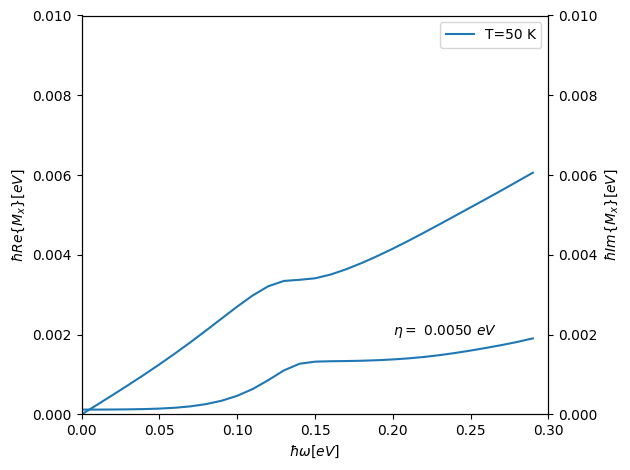

In [79]:
fig, *axs = setup_plot(y_lim=[0,0.01])
integrals = calculate_integral_points(mem_fn_ac, ws=torch.arange(0,0.3,0.01))
plot_real_and_imag_result(*axs, *integrals, T=T_0, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\3619451414.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


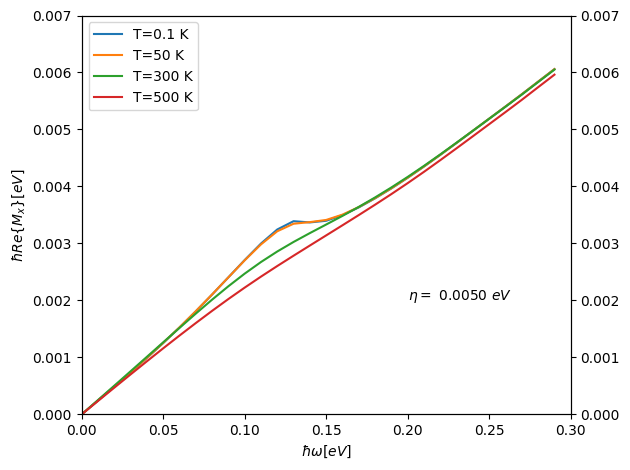

In [50]:
fig, *axs = setup_plot(imag=False, y_lim=[0,0.007])
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[0], T=T, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\1178216151.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


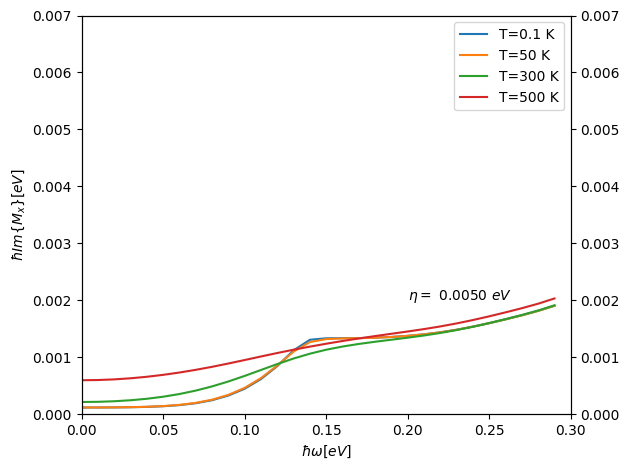

In [51]:
fig, *axs = setup_plot(real=False, y_lim=[0,0.007])
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[1], T=T, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

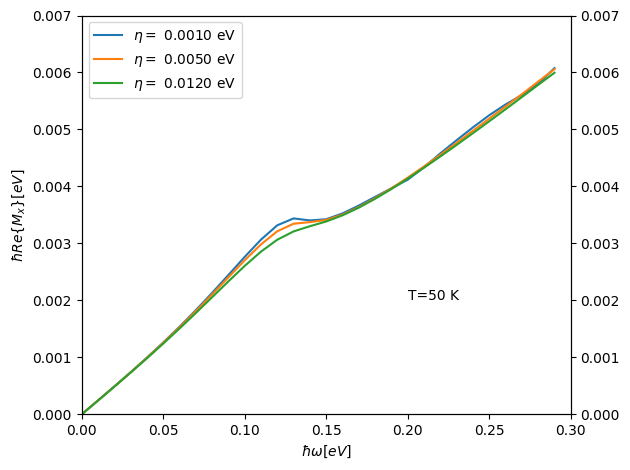

In [52]:
fig, *axs = setup_plot(imag=False, y_lim=[0,0.007])
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[0], eta=eta, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()

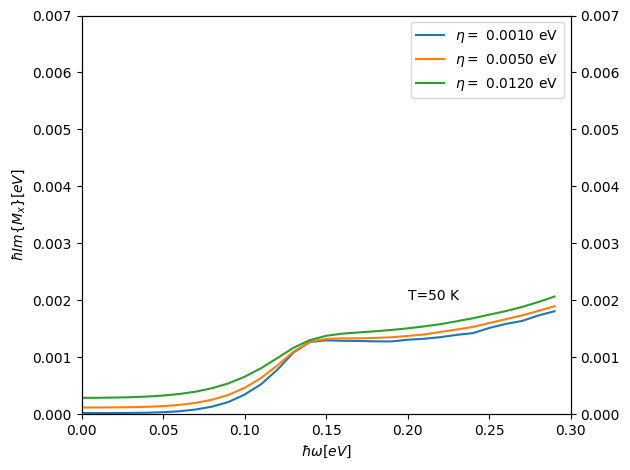

In [68]:
fig, *axs = setup_plot(real=False, y_lim=[0,0.007])
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[1], eta=eta, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()